In [1]:
import numpy as np
from scipy.stats import iqr
import dill
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import data_visualization as dv
import copy
import numba as nb
import time

import read_data_functions as rdf
import plot_functions as pf
from initializer import InitialThangs
from pathlib import Path
from Subject_Object_v3 import perc

np.set_printoptions(precision=3)


In [2]:
from Optimal_Stopping_Object import ModelConstructor,ModelFitting

%load_ext autoreload
%autoreload 2 

# Initial Thangs


In [3]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# SELECT EXPERIMENT
experiment = "Exp1"

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [23]:
# if 'group' not in locals():
group = rdf.generate_subject_object_v3(experiment,"Second Half")

# Create Model


Set inputs for model

In [24]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 25
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))]*it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
guess_leave_time_sd    = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2),axis=0)

#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward = 1.0
indecision_cost = 0.0
incorrect_cost = 0.0


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


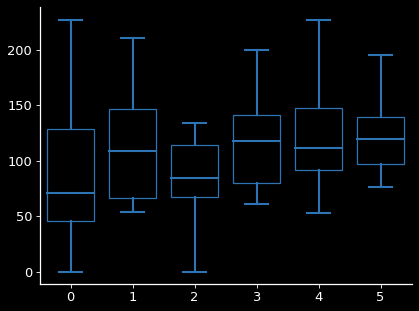

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


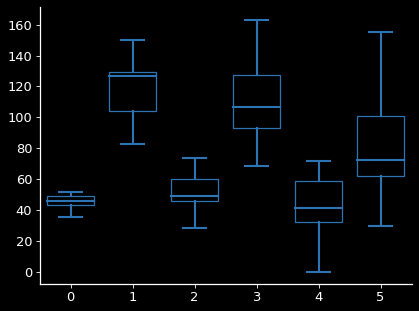

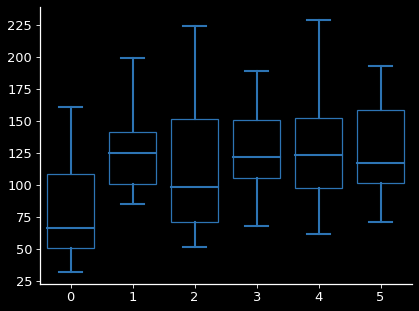

In [26]:
## CHecking out leave time sds 
# fig,ax =plt.subplots(dpi=75)
# xlocs = np.arange(0,it.num_blocks,1)
# pf.multi_boxplot(ax, np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2), xlocs)
# plt.show()

# fig,ax =plt.subplots(dpi=75)
# xlocs = np.arange(0,it.num_blocks,1)
# pf.multi_boxplot(ax, np.nanstd(group.react_guess_movement_metrics.movement_onset_times('react'),axis=2), xlocs)
# plt.show()

# fig,ax =plt.subplots(dpi=75)
# xlocs = np.arange(0,it.num_blocks,1)
# pf.multi_boxplot(ax, np.nanstd(group.movement_metrics.movement_onset_times('task'),axis=2), xlocs)
# plt.show()

In [27]:
free_params_init = {
                    'incorrect_cost': 0,
                    'indecision_cost':0,
}

# targets = np.array(
#     [np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2),axis=0),
#     np.nanmedian(group.player_perc_wins,axis=0)/100,
#     np.nanmedian(group.player_perc_incorrects,axis=0)/100,
#     np.nanmedian(group.player_perc_indecisions,axis=0)/100,
#     ]
# )

# metric_keys = ['wtd_leave_time','prob_win','prob_incorrect','prob_indecision']
# group.predict_stopping_times(model_known_switch.inputs.guess_delay["true"])
behavior_targets = np.array(
    [
        np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
        np.nanmedian(iqr(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
    ]
)
behavior_metric_keys = ["wtd_leave_time","wtd_leave_time_iqr"]

# UNUSED, gonna use behavior metrics and watch the results fall out
results_targets = np.array([[np.nanmedian(group.score_metrics.score_metric('indecisions')/it.num_blocks, axis=0)]])
results_metric_keys = ["prob_indecision"]

In [28]:
run_numba_quickly = ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=5,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]), 
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[0, 0]]).T, # Designed like this for broadcasting reasons
    guess_switch_sd=np.array([[0, 0]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    # electromechanical_sd=np.array([[10, 10]]).T,
    switch_cost_exists=False,
    expected=False,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

Run model without switch cost

In [48]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_regular_reward = ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]),
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[65, 0]]).T, # Designed like this for broadcasting reasons
    guess_switch_sd=np.array([[20, 0]]).T,
    # guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd]), # This includes electromechanical delay sd
    electromechanical_delay=np.array([[50,50]]).T,
    switch_cost_exists=True,
    expected=True,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)


Run model and fit the switch cost

In [49]:
#* Run true model and fit the guess delay
model_altered_reward = ModelConstructor(
     experiment=experiment,
    num_blocks=it.num_blocks,
    num_timesteps=1800,
    BETA_ON=False,
    agent_means=agent_means,
    agent_sds= agent_sds,
    reaction_time=np.array([rt, rt]),
    movement_time=np.array([mt, mt]),
    reaction_sd  =np.array([rt_sd, rt_sd]),
    movement_sd  =np.array([mt_sd, mt_sd]),
    timing_sd    =np.array([time_sd, time_sd]),
    perc_wins_when_both_reach=perc_wins_both_reach,
    guess_switch_delay=np.array([[65, 0]]).T, # Designed like this for broadcasting reasons
    guess_switch_sd=np.array([[20, 0]]).T,
    electromechanical_delay=np.array([[50, 50]]).T,
    switch_cost_exists=True,
    expected=True,
    win_reward=win_reward,
    incorrect_cost=incorrect_cost,
    indecision_cost=indecision_cost,
)

if True:
    model_fit_object = ModelFitting(model=model_altered_reward)
    res = model_fit_object.run_model_fit_procedure(
        free_params_init=free_params_init,
        targets=behavior_targets,
        drop_condition_from_loss=4,  # Drop 1200 50
        metric_keys=behavior_metric_keys,
        bnds=None,
        tol=0.000000001,
        method="Powell",
    )
    print(f'Initial Parameters: {free_params_init}')
    print(f'Win Reward: {model_altered_reward.inputs.win_reward}')
    print(f'Incorrect Cost: {model_altered_reward.inputs.incorrect_cost}')
    print(f'Indecision Cost: {model_altered_reward.inputs.indecision_cost}')

Initial Parameters: {'incorrect_cost': 0, 'indecision_cost': 0}
Win Reward: 1.0
Incorrect Cost: -0.08455809065784727
Indecision Cost: 0.0007286789807329941


Plot loss map

In [50]:
if True:
    if model_fit_object.parameter_arr.ndim==1:
        plt.ioff()
        params = np.array(model_fit_object.parameter_arr)
        loss = model_fit_object.loss_store
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(params, loss)
        ax.set_xlabel('Guess Delay')
        ax.set_ylabel('Loss')
        ax.set_ylim(0,6)
        plt.show()


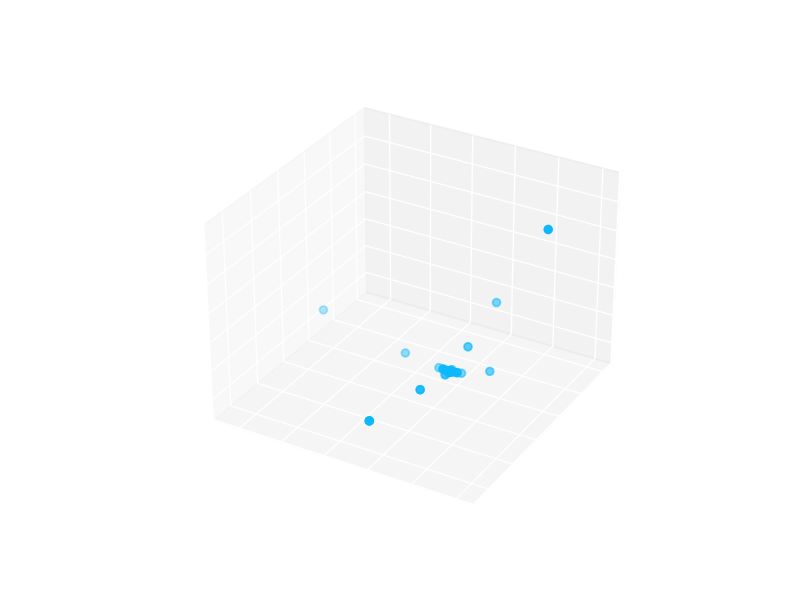

In [51]:
%matplotlib widget

if model_fit_object.parameter_arr.squeeze().ndim>1:
    plt.ion()
    params = np.array(model_fit_object.parameter_arr)
    loss = model_fit_object.loss_store
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(params[:,0], params[:,1], loss)
    ax.set_xlabel('Guess Delay')
    ax.set_ylabel('Guess SD')
    plt.show()

## Shorten the function names


In [52]:
get_regular_metric = model_regular_reward.results.get_metric
get_altered_metric = model_altered_reward.results.get_metric

# Plots


In [53]:
save = False

In [54]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_guess','prob_selecting_reaction'])

Predicted Decision Time


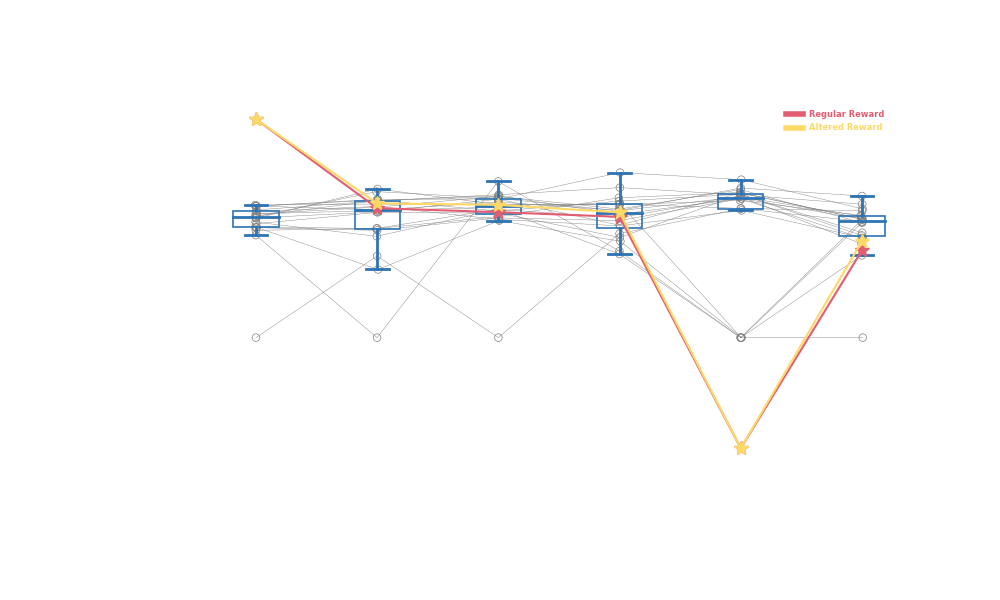

In [67]:
from matplotlib.pyplot import xticks


metric = group.decision_metrics.player_stopping_times
regular_reward_metric = model_regular_reward.results.optimal_decision_time[0]
altered_reward_metric = model_altered_reward.results.optimal_decision_time[0]

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Time (ms)',
    title='Predicted Decision Time'
)
# ax.set_ylim(600,1500)

if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

LEave Target Time


In [71]:
get_regular_metric(model_regular_reward.player_behavior.wtd_leave_time,decision_type='optimal')

array([1239.135, 1189.649, 1258.18 , 1196.744,  962.02 , 1116.428])

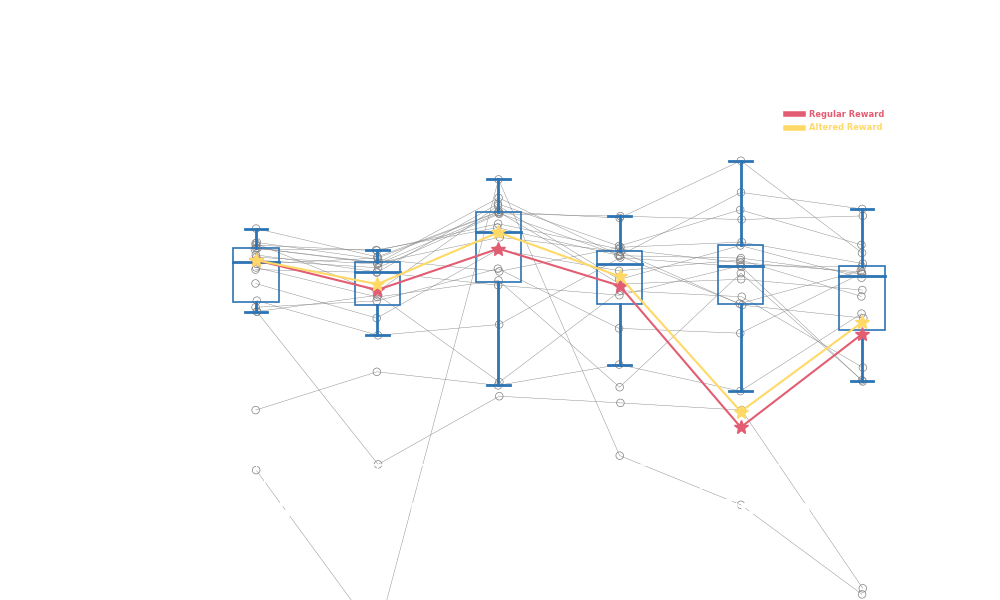

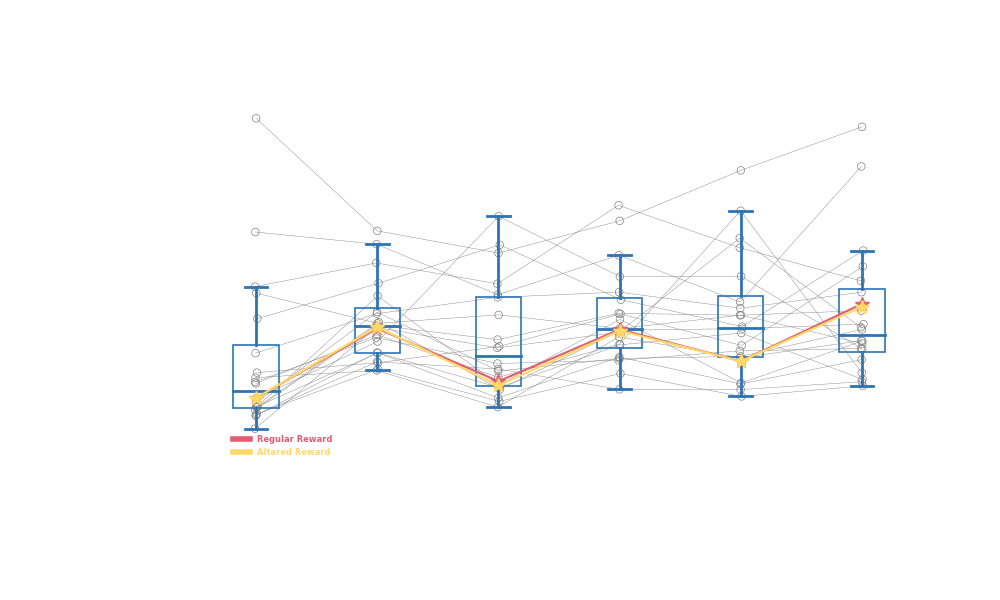

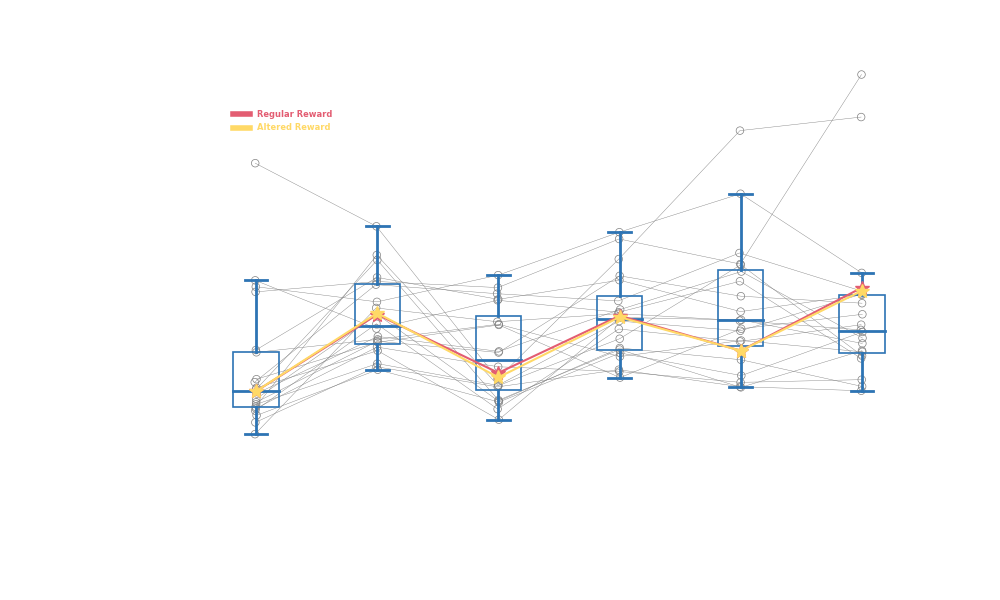

In [69]:
metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
regular_reward_metric = get_regular_metric(model_regular_reward.player_behavior.wtd_leave_time,decision_type='optimal')
altered_reward_metric = get_altered_metric(model_altered_reward.player_behavior.wtd_leave_time,decision_type='optimal')
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Time (ms)',
    title='Movement Onset Time'
)
ax.set_ylim(min(ylocs), max(ylocs))

if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

##########################################

metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
regular_reward_metric = get_regular_metric(model_regular_reward.player_behavior.wtd_leave_time_sd,decision_type='optimal')
altered_reward_metric = get_altered_metric(model_altered_reward.player_behavior.wtd_leave_time_sd,decision_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Time (ms)',
    title='Movement Onset Time SD'
)
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.guess_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

###################################
metric = iqr(group.movement_metrics.movement_onset_times('task'), axis=2)
regular_reward_metric = get_regular_metric(model_regular_reward.player_behavior.wtd_leave_time_iqr,decision_type='optimal')
altered_reward_metric = get_altered_metric(model_altered_reward.player_behavior.wtd_leave_time_iqr,decision_type='optimal')

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 400, 100)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Time (ms)',
    title='IQR Movement Onset Time'
)
ax.set_ylim(0,400)
# ax.plot(xlocs,get_exp_metric(np.sqrt(model_unknown.player_behavior.guess_reach_time_sd**2)))
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

Wins


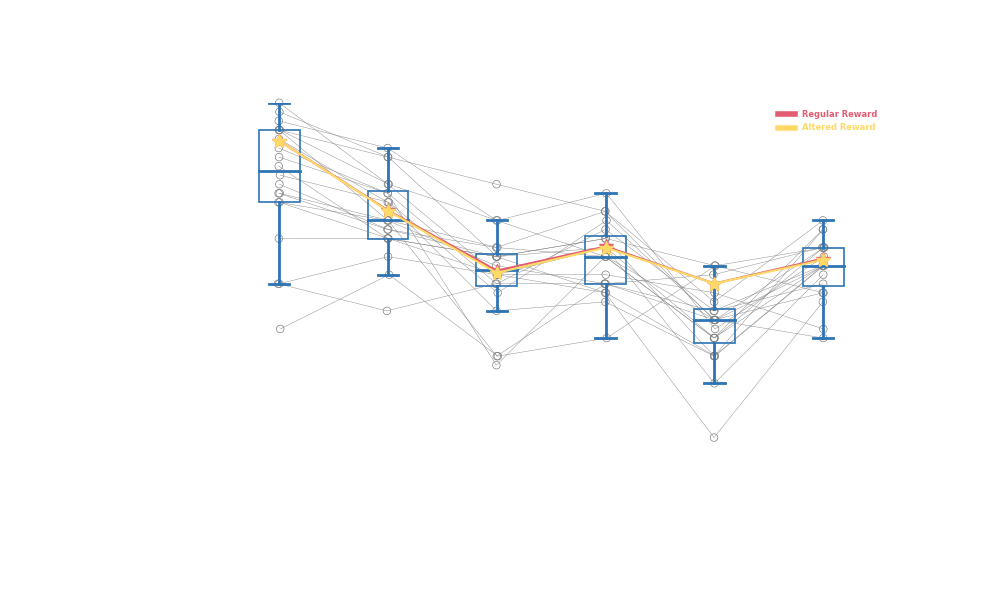

In [74]:
metric = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
regular_reward_metric = get_regular_metric(model_regular_reward.score_metrics.prob_win,decision_type='optimal')*100
altered_reward_metric = get_altered_metric(model_altered_reward.score_metrics.prob_win,decision_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Wins (%)',
    title='Wins',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Points


In [60]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_altered_reward.expected_reward.exp_reward, metric_type="fit")*group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_unknown.expected_reward.exp_reward, metric_type="fit")*group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_altered_reward.expected_reward.exp_reward, metric_type='true')*group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_altered_reward.expected_reward.exp_reward, metric_type='true')*group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        
    )
    ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


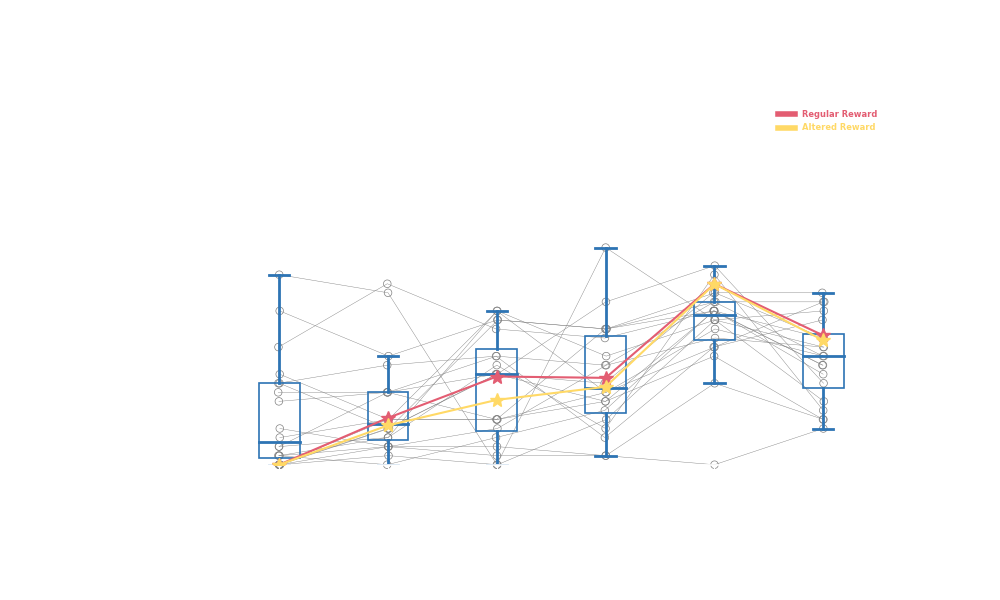

In [75]:
metric = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
regular_reward_metric = get_regular_metric(model_regular_reward.score_metrics.prob_incorrect,decision_type='optimal')*100
altered_reward_metric = get_altered_metric(model_altered_reward.score_metrics.prob_incorrect,decision_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Incorrects (%)',
    title='Incorrects',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


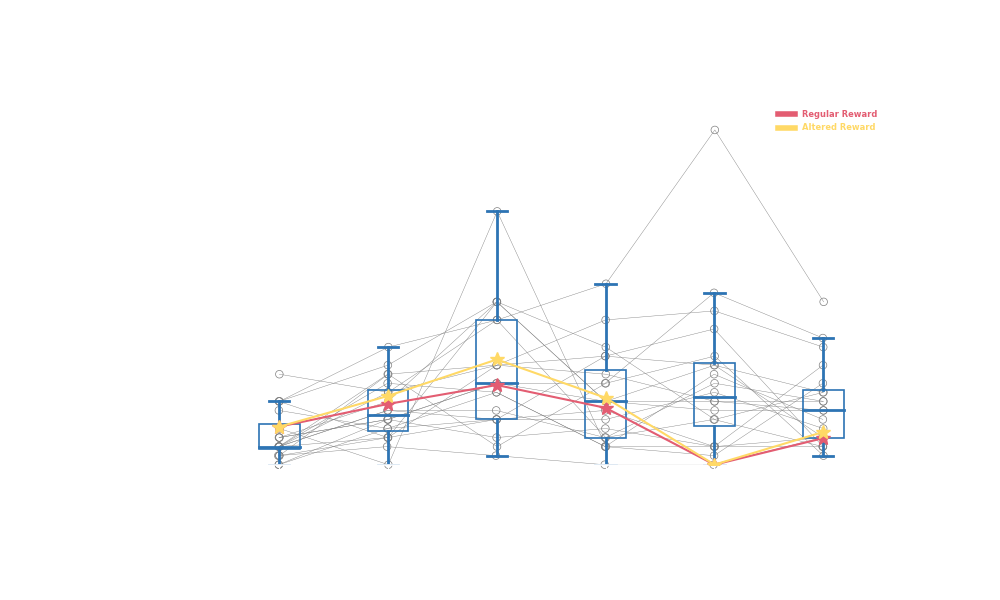

In [76]:
metric = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
regular_reward_metric = get_regular_metric(model_regular_reward.score_metrics.prob_indecision,decision_type='optimal')*100
altered_reward_metric = get_altered_metric(model_altered_reward.score_metrics.prob_indecision,decision_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Indecisions (%)',
    title='Indecisions',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins, Incorrects, Indecisions on One plot


Correct Initial Decisions


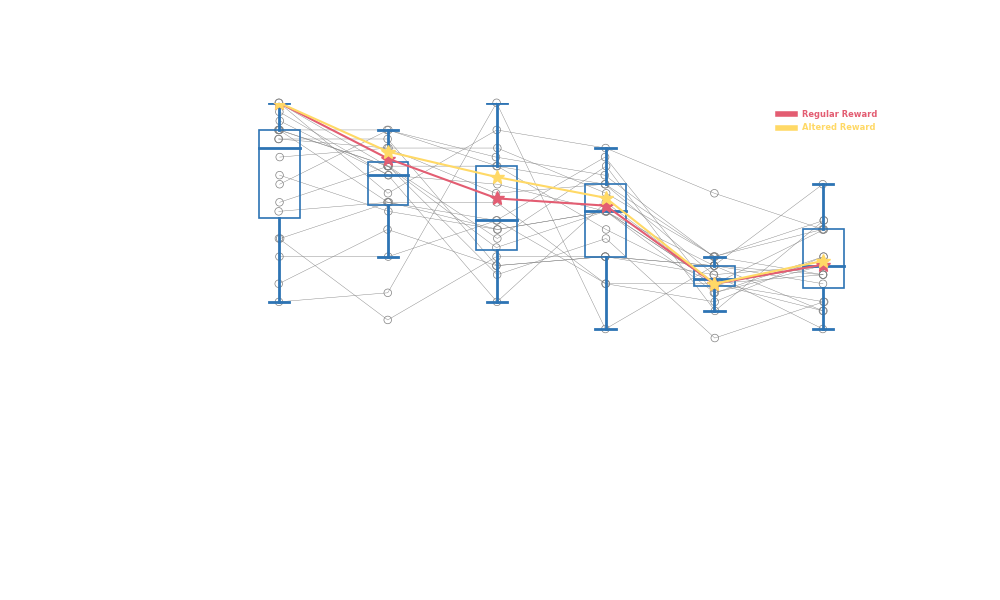

In [78]:
metric = group.movement_metrics.correct_initial_decisions/group.exp_info.num_task_trials*100
regular_reward_metric = get_regular_metric(model_regular_reward.score_metrics.correct_decisions,decision_type='optimal')*100
altered_reward_metric = get_altered_metric(model_altered_reward.score_metrics.correct_decisions,decision_type='optimal')*100

w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=[regular_reward_metric, altered_reward_metric],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Correct Decisions (%)',
    title='Correct Decisions',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "correct_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions


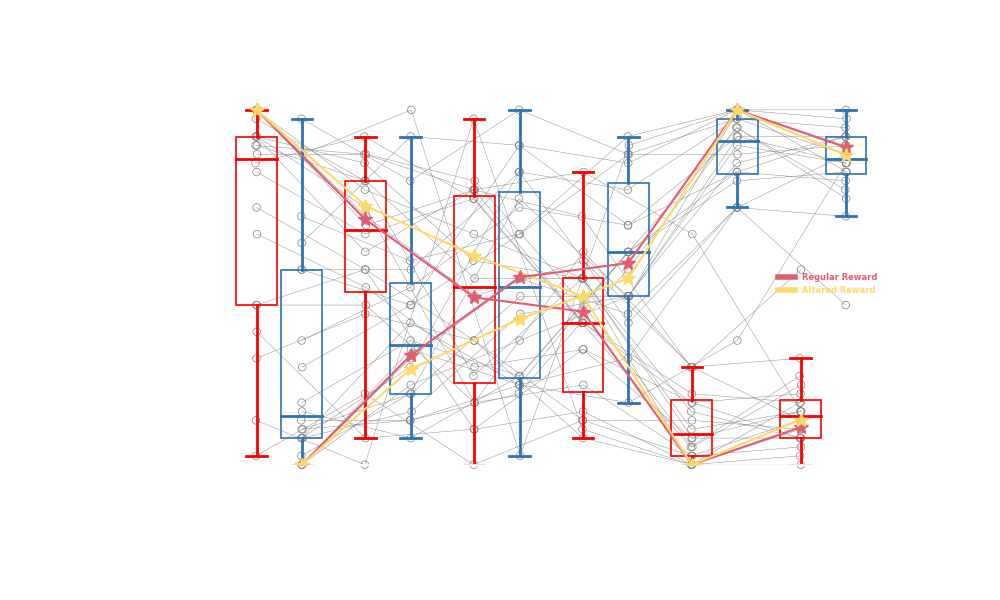

In [79]:
metric1 = group.react_guess_score_metrics.react_guess_decisions('react')/group.exp_info.num_task_trials*100
metric2 = group.react_guess_score_metrics.react_guess_decisions('guess')/group.exp_info.num_task_trials*100
regular_reward_metric1 = get_regular_metric(model_regular_reward.player_behavior.prob_selecting_reaction, metric_type="true")*100
regular_reward_metric2 = get_regular_metric(model_regular_reward.player_behavior.prob_selecting_guess, metric_type="true")*100
altered_reward_metric1 = get_altered_metric(model_altered_reward.player_behavior.prob_selecting_reaction, metric_type="true")*100
altered_reward_metric2 = get_altered_metric(model_altered_reward.player_behavior.prob_selecting_guess, metric_type="true")*100

# no_switch_metric2 = get_regular_metric(model_regular_reward.player_behavior.prob_selecting_guess, metric_type='true')*100
# switch_metric2 = get_altered_metric(model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    xlocs=xlocs-bw/1.8,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Percent (%)',
    title='Reaction/Guess Decisions',
)


pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric2,
    model_data_list=[regular_reward_metric2, altered_reward_metric2],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs + bw/1.8,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Percent (%)',
    title='Reaction/Guess Decisions',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


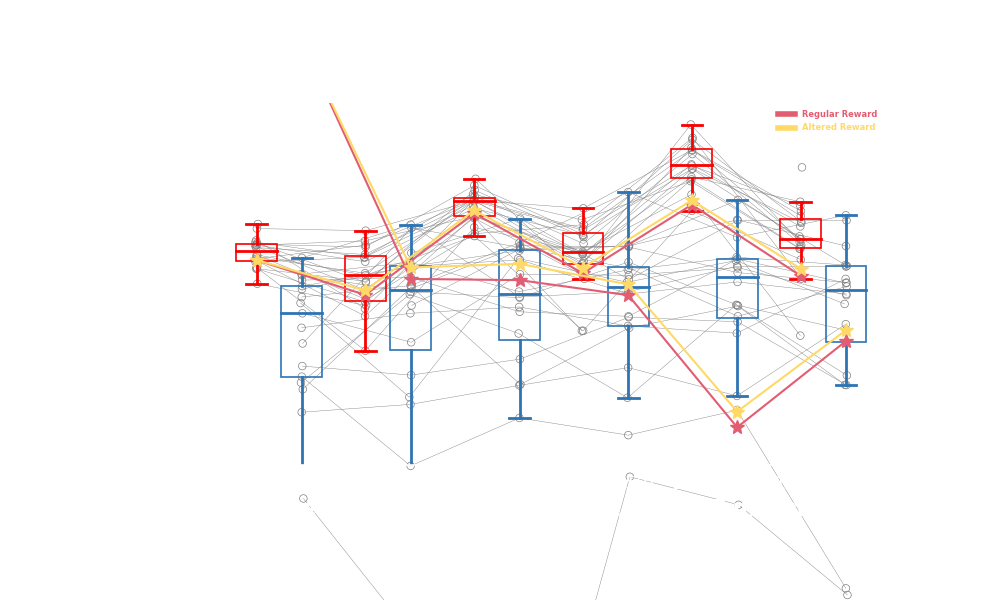

In [65]:
metric1 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('react'), axis=2)
metric2 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2)

regular_reward_metric1 = get_regular_metric(model_regular_reward.player_behavior.reaction_leave_time, metric_type='true')
altered_reward_metric1 = get_altered_metric(model_altered_reward.player_behavior.reaction_leave_time, metric_type='true')
unknown_switch_metric1 = get_regular_metric(model_altered_reward.player_behavior.reaction_leave_time, metric_type='true')

regular_reward_metric2 = get_regular_metric(model_regular_reward.player_behavior.guess_leave_time, metric_type='true')
altered_reward_metric2 = get_altered_metric(model_altered_reward.player_behavior.guess_leave_time, metric_type='true')
unknown_switch_metric2 = get_regular_metric(model_altered_reward.player_behavior.guess_leave_time, metric_type='true')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    xlocs=xlocs-bw/1.8,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Percent (%)',
    title='Reaction/Guess Decisions',
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric2,
    model_data_list=[regular_reward_metric2, altered_reward_metric2],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    box_width=bw,
    colors=wheel.seth_blue,
    linestyles=["-"]*4,
    xlocs=xlocs + bw/1.8,
    ylocs=ylocs,
    xticklabels=it.trial_block_titles,
    xlabel=it.xlabel,
    ylabel='Percent (%)',
    title='Reaction/Guess Decisions',
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Movement Onset Times


In [66]:
data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time, axis=2)
data_metric2 = np.nanmedian(group.agent_guess_task_leave_time, axis=2)

regular_reward_metric1 = get_regular_metric(model_regular_reward.agent_behavior.reaction_leave_time, metric_type='true')
altered_reward_metric1 = get_altered_metric(model_altered_reward.agent_behavior.reaction_leave_time, metric_type='true')
unknown_switch_metric1 = get_regular_metric(model_altered_reward.agent_behavior.reaction_leave_time, metric_type='true')

no_switch_metric2 = get_regular_metric(model_regular_reward.agent_behavior.guess_leave_time, metric_type='true')
switch_metric2 = get_altered_metric(model_altered_reward.agent_behavior.guess_leave_time, metric_type='true')
unknown_switch_metric2 = get_regular_metric(model_altered_reward.agent_behavior.guess_leave_time, metric_type='true')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1650, 150)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Agent Movement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

AttributeError: 'SubjectBuilder' object has no attribute 'agent_reaction_task_leave_time'

Wins That Were Reaction and guess

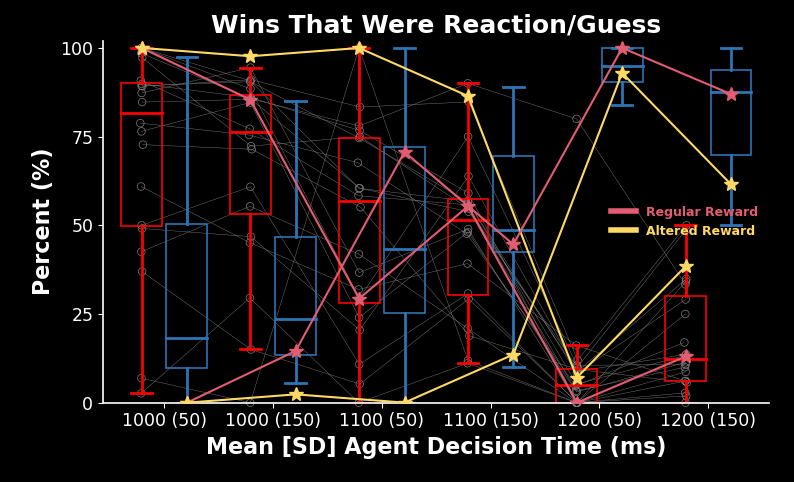

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions
data_metric2 = group.perc_wins_that_were_guesss

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_win_reaction, 
    model_regular_reward.score_metrics.prob_win, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.score_metrics.prob_win, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.score_metrics.prob_win, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_win_guess, 
    model_regular_reward.score_metrics.prob_win, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_win_guess, 
    model_altered_reward.score_metrics.prob_win, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_win_guess, 
    model_altered_reward.score_metrics.prob_win, metric_type='true'
)*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


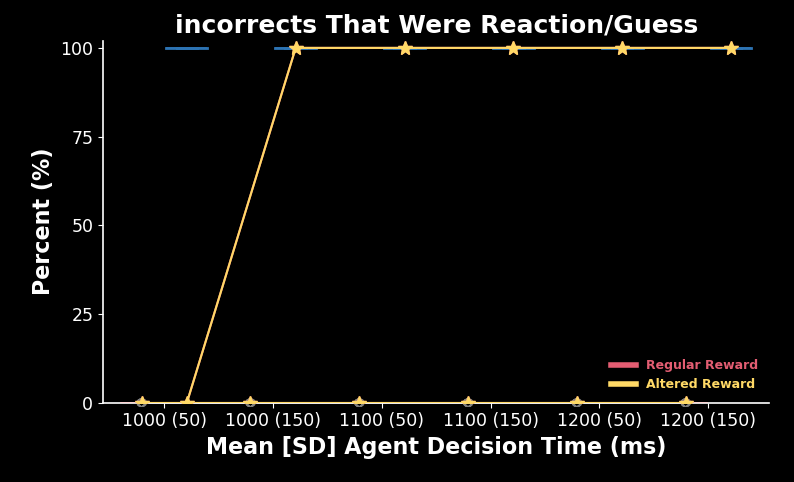

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions
data_metric2 = group.perc_incorrects_that_were_guesss

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_incorrect_reaction, 
    model_regular_reward.score_metrics.prob_incorrect, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_incorrect_guess, 
    model_regular_reward.score_metrics.prob_incorrect, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_incorrect_guess, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_incorrect_guess, 
    model_altered_reward.score_metrics.prob_incorrect, metric_type='true'
)*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/guess


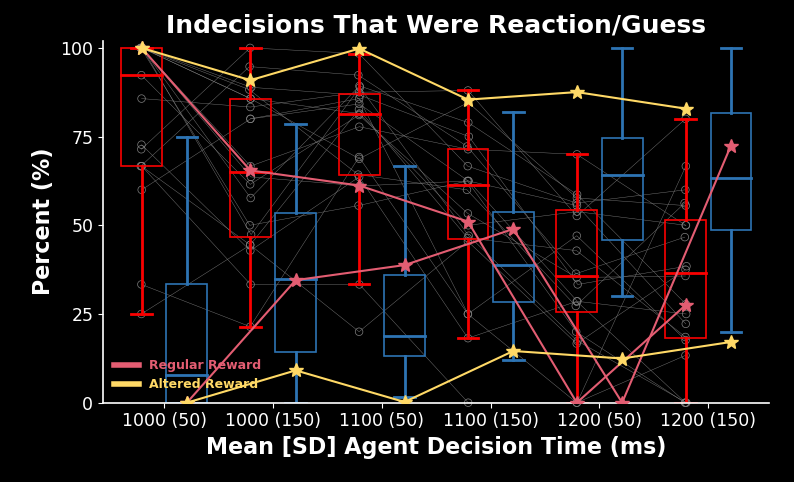

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions
data_metric2 = group.perc_indecisions_that_were_guesss

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_indecision_reaction, 
    model_regular_reward.score_metrics.prob_indecision, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.score_metrics.prob_indecision, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.score_metrics.prob_indecision, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_indecision_guess, 
    model_regular_reward.score_metrics.prob_indecision, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_indecision_guess, 
    model_altered_reward.score_metrics.prob_indecision, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_indecision_guess, 
    model_altered_reward.score_metrics.prob_indecision, metric_type='true'
)*100
# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/guess How many times did they win


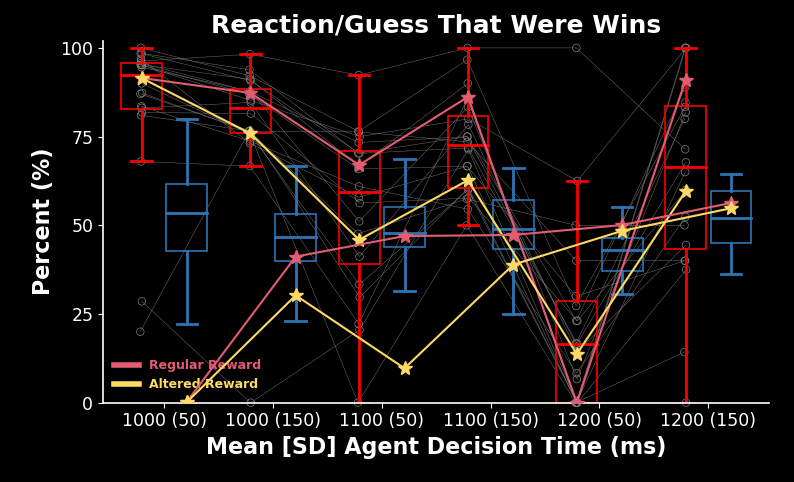

In [ ]:
#
#*Out of x number of reactions/guesss, how many were wins
data_metric1 = group.perc_reactions_that_were_wins
data_metric2 = group.perc_guesss_that_were_wins

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_win_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_win_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_win_guess, 
    model_regular_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_win_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_win_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Incorrects


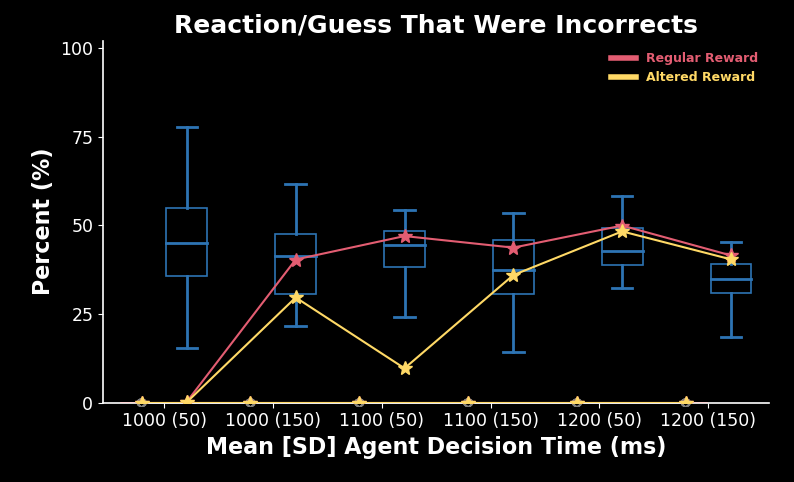

In [ ]:
#
#*Out of x number of reactions/guesss, how many were incorrects
data_metric1 = group.perc_reactions_that_were_incorrects
data_metric2 = group.perc_guesss_that_were_incorrects

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_incorrect_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_incorrect_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_incorrect_guess, 
    model_regular_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_incorrect_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_incorrect_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

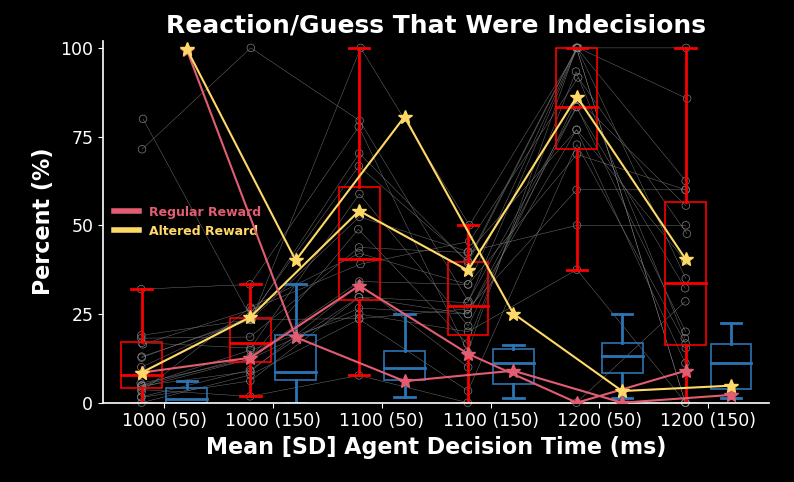

In [ ]:
#
#*Out of x number of reactions/guesss, how many were indecisions
data_metric1 = group.perc_reactions_that_were_indecisions
data_metric2 = group.perc_guesss_that_were_indecisions

regular_reward_metric1 = get_regular_metric(
    model_regular_reward.score_metrics.prob_indecision_reaction, 
    model_regular_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
altered_reward_metric1 = get_altered_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100
unknown_switch_metric1 = get_regular_metric(
    model_altered_reward.score_metrics.prob_indecision_reaction, 
    model_altered_reward.player_behavior.prob_selecting_reaction, metric_type='true'
)*100

no_switch_metric2 = get_regular_metric(
    model_regular_reward.score_metrics.prob_indecision_guess, 
    model_regular_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
switch_metric2 = get_altered_metric(
    model_altered_reward.score_metrics.prob_indecision_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100
unknown_switch_metric2 = get_regular_metric(
    model_altered_reward.score_metrics.prob_indecision_guess, 
    model_altered_reward.player_behavior.prob_selecting_guess, metric_type='true'
)*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data_list=[regular_reward_metric1, altered_reward_metric1],
    labels=['Regular Reward','Altered Reward'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    box_width=bw,
    colors=wheel.seth_red,
    linestyles=["-"]*4,
    
)

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data_list=[no_switch_metric2, switch_metric2],
    labels=['Regular Reward','Altered Reward'],
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.seth_blue,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5*bw, max(xlocs) + 1.5*bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()